# Scratchpad 3 - Pre-train LLM, learning rate scheduling, gradient clipping

## 1. Calculate text generation loss: cross-entropy and perplexity

### 1.1 Cross-entropy loss (average negative log probability value)

The model generates logits tensor of (batch_size, seq_length, vocab_size), the last dimension can be interpreted as the mode's predicted probability of each token in the whole vacabulary of being the next token. Applying `softmax` makes them probability values from 0 to 1, sumning up to 1.

For the target tokens (the input tokens minus the first token and plus the real next token in the training data), we want to maximize their logits in the output tokens. Which means we want to
-  **maximize the target tokens' softmax-ed values in the ouput tensor to 1**. 

It's easier to do this if we first calculate their log values, because to max the probabilities to 1, then we just need to maximize their log values (which are negative numbers) to 0. 

In ML we need to define a loss function and minimize one loss value calculated from the function. So instead of maximizing muliple log values of all the batches' ouput token sequences, we define the loss to be the 
- **averaged negative log probability value** of all target tokens in the output tensor, from all batches in the output concatenated. 

This is our **cross-entropy** loss. PyTorch provides a `cross_entropy` function which combines two operations:
- apply softmax 
- calculate log of softmax
- calculate negative log-likelihood loss
- average loss across batches

To use it, we need to flatten the logits tensor and the target token IDs batch tensor (aka concat all batches):

```
loss = torch.nn.functional.cross_entropy(logits_flat, target_idx_batch_flat)
```

Let's try it out.

In [2]:
from gpt.gpt_model import GPTModel
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "embedding_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "dropout_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

model = GPTModel(GPT_CONFIG_124M)
model.eval(); # ; is used to suppress the output

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
full_text = "The quick brown fox jumps over the lazy dog"
full_text_tokens = tokenizer.encode(full_text)
print(f"Full text tokens: {full_text_tokens}")

Full text tokens: [464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290]


In [5]:
input_idx = full_text_tokens[:4]
input_text = tokenizer.decode(input_idx)
print(f"Input text: {input_text}")
input_idx_batch = torch.tensor(input_idx).unsqueeze(0)
print(f"Input idx batch tensor: {input_idx_batch}")

Input text: The quick brown fox
Input idx batch tensor: tensor([[  464,  2068,  7586, 21831]])


In [6]:
with torch.no_grad():
    logits = model(input_idx_batch)
print(f"Output logits shape: {logits.shape}")

Output logits shape: torch.Size([1, 4, 50257])


In [7]:
target_idx = full_text_tokens[1:5]
target_text = tokenizer.decode(target_idx)
print(f"Target text: {target_text}")
target_idx_batch = torch.tensor(target_idx).unsqueeze(0)
print(f"Target idx batch tensor: {target_idx_batch}")

Target text:  quick brown fox jumps
Target idx batch tensor: tensor([[ 2068,  7586, 21831, 18045]])


In [8]:
# logits is the model's output of shape (batch_size, seq_len, vocab_size) -> (batch_size * seq_len, vocab_size)
logits_flat = logits.flatten(0, 1)
# targets is the target sequence's token IDs shape (batch_size, seq_len) -> (batch_size * seq_len)
targets_idx_flat = target_idx_batch.flatten(0, 1)
# Compute the cross entropy loss
loss = torch.nn.functional.cross_entropy(logits_flat, targets_idx_flat)
print(loss)

tensor(11.0766)


With our randomly initialized GPT2 model, the cross-entropy loss is greater than 10.

### 1.2 Perplexity

**Perplexity** is also a metric that measures how well the model predicts a sequence of tokens. It is the **exponential of the average negaltive log-likelihood** of the predicted probabilities for each token in a sequence, aka
- the **exponential of cross-entropy**
  
It tells us how "surprised" the model is by the test data. It can be interpreted as how many choices the model thinks it has when predicting the next token.

$$\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i)\right)$$

```
cros_entropy_loss = torch.nn.functional.cross_entropy(logits_flat, target_idx_batch_flat)
perplexity_loss = torch.exp(cros_entropy_loss)
```

- A perplexity of 1 means the model is extremely sure (assigns probability of 1 to the correct next token ID).
- A high perplexity means the model is uncertain about the next token.


In [9]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(64639.9336)


Our untrained model has perplexity of 46532, with the vocabulary size 50257, it is basically random guessing.

## 2. Training data pipeline

### 2.1 Create dataset

#### 2.1.1 Get data

Let's use a small dataset first. Download the "verdict.txt".

In [10]:
import os
import requests
from tqdm import tqdm


# download file from url to destination, showing progress bar
def download_file(url, destination):
    # Create the destination directory if it doesn't exist
    os.makedirs(os.path.dirname(destination), exist_ok=True)
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(
        total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description
    ) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file


In [11]:
data_folder = "data"
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

destination = os.path.join(data_folder, file_path)
download_file(url, destination)

the-verdict.txt: 20.5kiB [00:00, 14.7MiB/s]                  


In [12]:
with open(destination, 'r', encoding='utf-8') as file:
    text_data = file.read()
print(text_data[:99])
print(text_data[200:299])
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
 rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would h
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

total_tokens = tokenizer.encode(text_data)
print(f"Total characters: {len(text_data)}")
print(f"Total number of tokens: {len(total_tokens)}")

Total characters: 20479
Total number of tokens: 5145


#### 2.1.2 Create custom dataset

We'll create a custom DataSet which extends PyTorch's `Dataset` to prepare an LLM training dataset, which
- tokenizes the text dataset with a given tokenizer 
- chunks the text dataset into multiple chunks of max_length, with the specified stride
- using a sliding window when chunking, so that
  - input is a sequence of token ids
  - target is one token slided right of the input token id sequence

We do this by preprocessing logic in `__init__` method and then override the `__len__` method and `__getitem__` method.

In [14]:
from torch.utils.data import Dataset
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

### 2.2 Create data loader

Then we can use this custom dataset in PyTorch's `DataLoader`, which takes care of data batching, shuffling, parallel data loading, etc.

In [15]:
from torch.utils.data import DataLoader
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

With those prepared, let's split the dataset into training and validation at ratio 9:1.

In [16]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Then let's create the dataloaders for training and validation datasets. 
- For faster training, we change the model config's context_length from 1024 to 256
- We set `drop_last=True` in the datalodaer so that if there are not enough samples left to form a full batch at the end of the dataset, we drop this smaller final batch.

In [17]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length !! Let's use 256 context length for faster training
    "embedding_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "dropout_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Sanity check if the data is enough to cover at least context length.

In [18]:
if len(total_tokens) * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if len(total_tokens) * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

Check that data was loaded correctly.

In [19]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Check that token size is in the expected ballpark (we droped the last smaller batch so it is smaller than the full dataset).

In [20]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### 2.3 Calculate loss batch

We implement two utils functions to calculate `cross-entropy` loss. 

One is for a given batch. We will use the model to generate logits for this input batch, then use PyTorch's cross entropy loss implementation `torch.nn.functional.cross_entropy`, passing in flattened batch `logits` and flattened batch `target_batch` IDs

In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

Then we can calculates loss for multiple batches across a dataloder. We calculate each batch's loss then get the average loss of all batches we're interested in the dataloder.

In [22]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [23]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


(MPS seems to get faster the second time round)

In [24]:
import time
import torch

device = "mps"

torch.manual_seed(1234)
TENSOR_A_CPU = torch.rand(5000, 5000)
TENSOR_B_CPU = torch.rand(5000, 5000)

torch.manual_seed(1234)
TENSOR_A_MPS = torch.rand(5000, 5000).to(device)
TENSOR_B_MPS = torch.rand(5000, 5000).to(device)

# Warm-up
for _ in range(100):
    torch.matmul(torch.rand(500,500).to(device), torch.rand(500,500).to(device))
    
start_time = time.time()
torch.matmul(TENSOR_A_CPU, TENSOR_B_CPU)
print("CPU : --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
torch.matmul(TENSOR_A_MPS, TENSOR_B_MPS)
print("MPS : --- %s seconds ---" % (time.time() - start_time))

CPU : --- 0.32512903213500977 seconds ---
MPS : --- 0.13320231437683105 seconds ---


Now let's calculate the dataset's loss on an untrained model.

In [25]:
from gpt.gpt_model import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length !! Let's use 256 context length for faster training
    "embedding_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "dropout_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

model = GPTModel(GPT_CONFIG_124M).to(device)

In [26]:
torch.manual_seed(123)
with torch.no_grad(): # disable gradient tracking for efficiency as we're not yet training
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print(f"Initial train loss: {train_loss:.16f}")
print(f"Initial validation loss: {val_loss:.16f}")

Initial train loss: 11.0042010413275833
Initial validation loss: 10.9581489562988281


## 3. Train the LLM

### 3.1 Train and eval scripts

A simple training script that will give us `train_losses`, `val_losses`, and `track_tokens_seen` which tracks all tokens the model has seen.

In each epoch, we
- set the model in training mode
- go through each batch, wherein we
  - reset the optimizers gradients from the previous iteration: `optimizer.zero_grad()`
  - calculate loss of this batch (use the model to generate logits of the input_batch, then calculate cross entropy loss of the input_batch and target_batch)
  - calculate gradient using back propagation of the loss (`loss.backword()`)
  - update model weights using the optimizer with the gradients (`optimizer.step()`)
  - track tokens seen
  - every `eval_freq` steps, we print out the intermediate training results:
    - set the model in eval() mode
    - calculate loss across `eval_iter` batches
    - print the number of tokens seen, the intermediate train and val loss
    - use the model to do a text generation and print it out

In [27]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # main training loop
    for epoch in range(num_epochs):
        model.train()  # set model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # calculate gradients
            optimizer.step()  # update model weights
            tokens_seen += input_batch.numel()
            global_step += 1

            # intermediate evaluation
            if global_step % eval_freq == 0:
                model.eval()  # set model to evaluation mode
                with torch.no_grad():
                    train_loss = calc_loss_loader(
                        train_loader, model, device, eval_iter
                    )
                    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(
                        f"Epoch: {epoch}, Global step: {global_step}, "
                        f"Tokens seen: {tokens_seen}, Train loss: {train_loss:.4f}, "
                        f"Validation loss: {val_loss:.4f}"
                    )
                model.train()
        # print a samplet text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

Every epoch we print a text generation to see if the model is getting better. 

The `generate_and_print_sample` utility function:

In [28]:
from utils.generate_tokens import generate_tokens_greedy
import torch

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded_tensor = torch.tensor(tokenizer.encode(start_context)).unsqueeze(0).to(device)
    with torch.no_grad():
        token_ids = generate_tokens_greedy(
            model=model,
            input_idx_batch=encoded_tensor,
            max_new_tokens=50,
            context_size=context_size,
        )
    decoded_text = tokenizer.decode(token_ids.squeeze(0).tolist())
    print(decoded_text.replace("\n", " "))
    model.train()

Now let's train the LLM using the above training script.

In [29]:
import time
import torch
from gpt.gpt_model import GPTModel

start_time = time.time()
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length !! Let's use 256 context length for faster training
    "embedding_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "dropout_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training took {execution_time_minutes:.2f} minutes")

Epoch: 0, Global step: 0, Tokens seen: 512, Train loss: 10.0420, Validation loss: 10.0227
Epoch: 0, Global step: 5, Tokens seen: 3072, Train loss: 8.1697, Validation loss: 8.3290
Every effort moves you,,,,, the,,,,,,, the,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,
Epoch: 1, Global step: 10, Tokens seen: 5632, Train loss: 6.7131, Validation loss: 7.0844
Epoch: 1, Global step: 15, Tokens seen: 8192, Train loss: 6.1807, Validation loss: 6.6203
Every effort moves you, and, and, the, and, and, and, the, and, and, and, and, and, and, and, the, and, and, and, and, and, and, and,, and, the,
Epoch: 2, Global step: 20, Tokens seen: 10752, Train loss: 5.6658, Validation loss: 6.5348
Epoch: 2, Global step: 25, Tokens seen: 13312, Train loss: 5.6759, Validation loss: 6.4869
Every effort moves you .                                                 
Epoch: 3, Global step: 30, Tokens seen: 15872, Train loss: 5.2342, Validation loss: 6.4239
Epoch: 3, Global step: 35, Tokens seen: 18432, Train loss: 5.0158, 

### 3.2 Plot the training and validation losses

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Train Loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer ticks on x-axis

    # plot a second x-axis for tokens seen
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # create a dummy plot
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

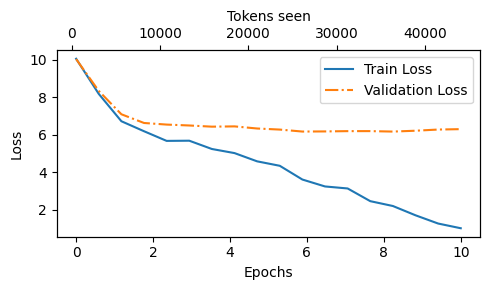

In [31]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

We can observe overfitting as at the beginning both train and val losses are going down, but after a couple of epochs only the train loss keeps going down while the val loss plateaued. 

The overfitting is because we have a very small training set and we're iterating over it many times.

## 4. Advanced LLM training

### 4.1 Learning rate warmup and cosine decay

#### Learning rate warmup

Gradually increase learning rate from a very low value (`initial_lr`, e.g. 0.0001) to a maximum value (`peak_lr`, e.g. 0.01). 

Benefit: stablize the training at the initial stage. Model training starts with samll weight updates, which can decrease the risk of large destablizing updates.

Typically, the number of warmup steps is between 0.1% to 10% of the total number of global training steps. We calculate each step's learning rate increment evenly.

In [32]:
initial_lr = 0.0001
peak_lr = 0.01
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% of total steps warm up
print(f"total steps: {total_steps}, warmup steps: {warmup_steps}")

total steps: 90, warmup steps: 18


#### Learning rate cosine decay

After warming up steps, decrease the learning rate across training epochs to near zero. In cosine decay, the learning rate decrease follows a half cosine cycle curve to near zero. 

Benefit: 
- stablize the training at its later stages. It's designed to slow down the pace of weight update and reduce the risk of overshooting minima as the training progresses. 
- Cosine decay is often preferred over linear decay for its smoother transition in learing rate adjustments. But linear decay is also used in practice.

In [33]:
import math

initial_lr = 0.0001

# for lr warmup
peak_lr = 0.01
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% of total steps warm up
lr_increment = (peak_lr - initial_lr) / warmup_steps
# for lr cosine decay
min_lr = 0.1 * initial_lr

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(num_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # linear warmup
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        # cosine annealing after warmup
        else:
            progress = (global_step - warmup_steps) / (total_steps - warmup_steps)
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        
        # apply the calculated learningg rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

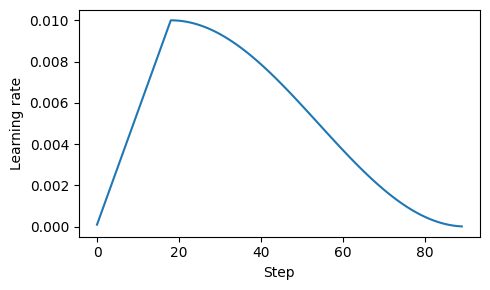

In [34]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_steps), track_lrs)
plt.tight_layout(); plt.savefig("lr-scheduler.pdf")
plt.show()

### 4.2 Gradient clipping

Scale down gradients exceeding a threshold (`max_norm`) to a maximum magnitude to ensure that the updates during backpropagation remain within a manageable range. 

The "norm" refers to the gradient matrices magnitudes, specifically, the L2 norm (Euclidian norm). E.g. with a vector $v = [v_1, v_2, ..., v_n]$, its L2 norm is mathematically:

$$\|v\|_2 = \sqrt{v_1^2 + v_2^2 + ... + v_n^2}$$

The L2 norm of a matrix is calculated similarly. With a gradient matrix

$$ G = \begin{bmatrix}
1 & 2 \\
2 & 4
\end{bmatrix} $$

The L2 norm is calculated as
$$ \|G\|_2 = \sqrt{1^2 + 2^2 + 2^2 + 4^2} = \sqrt{25} = 5$$

Gradient clipping scales the gradient matrix so that the norm will be no more than the specified maximum value. With $G$'s L2 norm being 5, and the specified `max_norm` being 1, we have the scaling factor:

$$ \frac{max\_norm}{\|G\|_2} = \frac{1}{5} $$

Therefore we scale the gradient matrix $G$ to $G'$ as follows:

$$ G' = G \times \frac{1}{5} = \begin{bmatrix}
\frac{1}{5} & \frac{2}{5} \\
\frac{2}{5} & \frac{4}{5}
\end{bmatrix}
$$

#### 4.2.1 Implementation

In PyTorch, using `max_norm=1.0` setting in the `clip_grad_norm_` method, we'll scale down the gradients so that their norm is less than 1.0.

First, we calculate the loss and call `loss.backward()`, which will calculate gradients and store them in the model's parameters' `.grad` attribute.

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M).to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [37]:
# a function to calculate the highest gradient from all model weights
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

In [38]:
print(find_highest_gradient(model))

tensor(0.0469, device='mps:0')


Now apply gradient clipping and see how the max gradient gets smaller.

In [ ]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


In [40]:
print(find_highest_gradient(model))

tensor(0.0213, device='mps:0')


### 4.3 Advanced training script

We extend the `train_model_simple` script to include learning rate warmup, cosine decal, and gradient clipping. 

The peak learning rate is the learning rate used to initialize the optimizer:

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

and we can access it from the optimizer like this:

In [43]:
peak_lr = optimizer.param_groups[0]["lr"]

The new training script:

In [51]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
    warmup_steps=None,  # lr warmup
    initial_lr=3e-5, # 0.00003
    min_lr=1e-6, # 0.000001
):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    num_tokens_seen, global_step = 0, -1

    # retrieve peak learning rate from optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # calculate total training steps
    total_steps = len(train_loader) * num_epochs

    # calculate linear warmup increment
    if warmup_steps is None:
        warmup_steps = int(0.2 * total_steps) # default to 20% warmup steps
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    # main training loop
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # linear learning rate warmup
            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment
            # cosine annealing after warmup
            else:
                progress = (global_step - warmup_steps) / (total_steps - warmup_steps)
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr) # store current learning rate

            # calculate loss and backpropagate
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # clip gradients to avoid exploding gradients
            if global_step >= warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step() # update model weights
            num_tokens_seen += input_batch.numel()

            # intermediate evaluation
            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = calc_loss_loader(
                        train_loader, model, device, eval_iter
                    )
                    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(
                        f"Epoch: {epoch}, Global step: {global_step}, "
                        f"Tokens seen: {num_tokens_seen}, Train loss: {train_loss:.4f}, "
                        f"Validation loss: {val_loss:.4f}"
                    )
                model.train()
        # print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen, track_lrs


Train a model with advanced training script:

In [52]:
import time
import torch
from gpt.gpt_model import GPTModel

start_time = time.time()
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length !! Let's use 256 context length for faster training
    "embedding_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "dropout_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

num_epochs = 10
train_losses, val_losses, tokens_seen, track_lrs = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
    warmup_steps=20,
    initial_lr=1e-5,
    min_lr=1e-5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training took {execution_time_minutes:.2f} minutes")

Epoch: 0, Global step: 0, Tokens seen: 512, Train loss: 10.9560, Validation loss: 10.9781
Epoch: 0, Global step: 5, Tokens seen: 3072, Train loss: 9.6291, Validation loss: 9.8220
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch: 1, Global step: 10, Tokens seen: 5632, Train loss: 8.6104, Validation loss: 8.9037
Epoch: 1, Global step: 15, Tokens seen: 8192, Train loss: 7.4828, Validation loss: 7.8671
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch: 2, Global step: 20, Tokens seen: 10752, Train loss: 6.3884, Validation loss: 6.8798
Epoch: 2, Global step: 25, Tokens seen: 13312, Train loss: 5.9455, Validation loss: 6.6037
Every effort moves you, the, the, the, the, the, the, the, the, the, the,, the, the, the, the, the, the, the, the, the, the,, the,, the, the,
Epoch: 3, Global step: 30, Tokens seen: 15872, Train loss: 14.1507, Validation loss: 14.9487
Epoch: 3, Global step: 35, Tokens seen: 18432, Train loss: 5.1034, Validation 

We saw that the learning gets much more slowly. The model is still overfit since our training data is too small.

Now let's plot the learning rates:

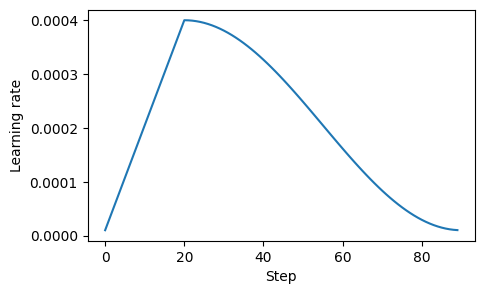

In [53]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(track_lrs)), track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.show()